

# Bike Sharing Demand - Forecasting use of a city bikeshare system



**Author:**  Rafal Jakubanis  <rafajak@gmail.com>

**Source of data:**  https://www.kaggle.com/c/bike-sharing-demand/data


<img src="./data/limebike.jpg">
                 
                                 Hope you'll enjoy reading this notebook!


### Table of contents

1. Introduction
2. Data import
3. Data exploration and preprocessing
4. Modelling
5. Conclusion

### 1. Introduction

Let's start off with importing required modules and taking a look at the data dictionary

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg


Variables included in the data: 

    datetime   - hourly date + timestamp  
    
    season     -  1 = spring,
                  2 = summer,
                  3 = fall,
                  4 = winter 
                  
    holiday    - whether the day is considered a holiday
    
    workingday - whether the day is neither a weekend nor holiday
    
    weather    -  1: Clear, Few clouds, Partly cloudy, Partly cloudy 
                  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
                  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
                 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
                 
    temp       - temperature in Celsius
    
    atemp      - "feels like" temperature in Celsius
    
    humidity   - relative humidity
    
    windspeed  - wind speed
    
    casual     - number of non-registered user rentals initiated
    
    registered - number of registered user rentals initiated
    
    count      - number of total rentals

### 2. Data import

In [213]:
data = pd.read_csv("./data/train.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 3. Data exploration and preprocessing

   

Let's import the train and test datasets.

In [212]:
train_df = pd.read_csv("./data/train.csv") 
test_df = pd.read_csv("./data/test.csv") 
combined_df = [train_df, test_df]

Let's look at descriptive statistics of this dataset to see if there's anything suggesting outliers or datapoints that seems to be erroneous.

In [192]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [193]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity 

Excellent, no missing data!

Before we go on and transform the data, let's run a Pearson correlation matrix to see if there are any bivariate correlations worth looking into in more detail.

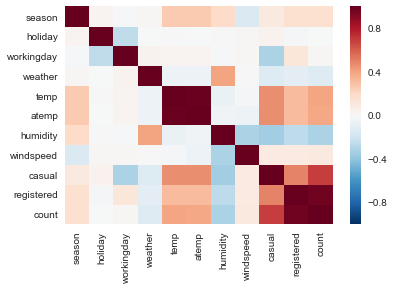

In [194]:
corr = train_df.corr(method='pearson')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

As one might expect, count of bike-users correlates with air temperature (and "feels like"-temperature), humidity (which is itself highly correlated with the categorical variable describing the weather).

Let's look at some of the variables individually to understand the data better and see if there are any outliers

In [195]:
train_df["datetime"].head()

0    2011-01-01 00:00:00
1    2011-01-01 01:00:00
2    2011-01-01 02:00:00
3    2011-01-01 03:00:00
4    2011-01-01 04:00:00
Name: datetime, dtype: object

The format of the datetime variable is not suitable for analysis - let's use pandas to extract days of the month/week, years, and hours from it.

Additionally, I'll encode hours, months, and days of the week to preserve their cyclical nature. 
I got this idea from https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes
  

In [196]:
for df in combined_df:
    date = pd.DatetimeIndex(df['datetime'])

    df['month'] = date.month
    df['year'] = date.year
    df['hour'] = date.hour
    df['day_of_week'] = date.dayofweek

    # # Let's encode hours, months, and days of the week to preserve their cyclical nature 
    df['hour_sin'] = np.sin(df.hour*(2.*np.pi/24))
    df['hour_cos'] = np.cos(df.hour*(2.*np.pi/24))

    df['dow_sin'] = np.sin(df.day_of_week*(2.*np.pi/7))
    df['dow_cos'] = np.cos(df.day_of_week*(2.*np.pi/7))

    df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

    df.drop('datetime', axis = 1, inplace = True)

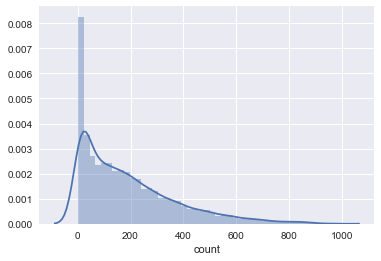

In [197]:
sns.distplot(train_df["count"])

The dependent variable is quite skewed - log1p-transforming seems to be a sensible option (as disproportionately many values are 0).

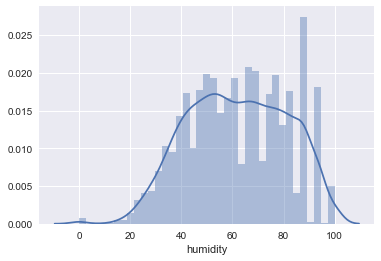

In [198]:
sns.distplot(train_df["humidity"])

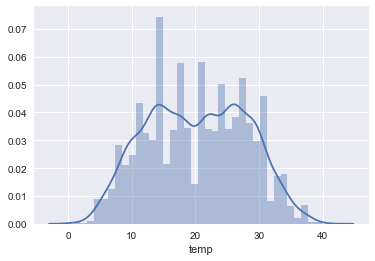

In [199]:
sns.distplot(train_df["temp"])


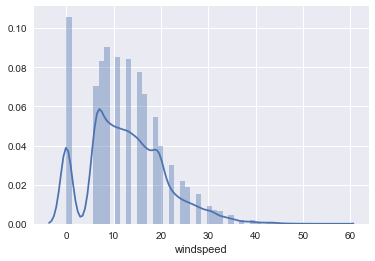

In [15]:
sns.distplot(train_df["windspeed"])


Windspeed has an odd distribution, too. Windspeed of 0 is overrepresented in this sample, although it's generally unlikely to occur in real life [citation needed]. This may mean the device collecting the data is very insensitive to wind slower than 6km/h and assigning value of 0 to such measurements. 

I could imput the values for windspeed<=6, but looking back at the correlation matrix, this variable might not be particularly useful to include in the models. I might abandon this feature for now (and perhaps come crawling back when my models' performance turns out to be terrible).

Let's explore how different months, days, and time of day influence demand. 

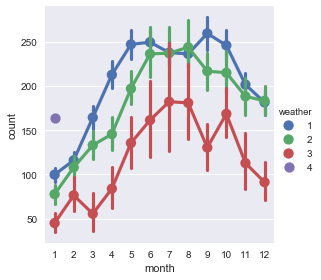

In [202]:
g= sns.factorplot(data = train_df,
               x = "month",
               y = "count",
               hue = "weather",
               ci = 95
               ) 

People are more likely to cycle during warmer months - that makes intuitive sense.


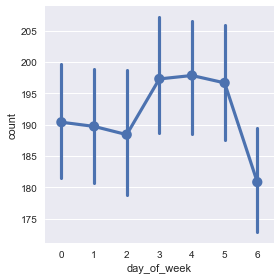

In [203]:
sns.factorplot(data = train_df,
               x = "day_of_week",
               y = "count", 
#              hue = "weather", #too noisy to be informative
               ci = 95
               ) 

The mean demand seems to be the lowest on Sundays, although the 95% confidence intervals are overlapping.

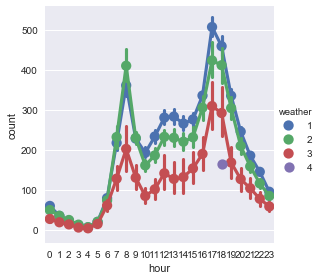

In [204]:
sns.factorplot(data = train_df,
               x = "hour",
               y = "count", 
               hue = "weather",
               ci = 95
               ) 

The peaks in demand happen during the communiting hours - I'm curious about how the demand over cyclical timeframes varies for the two casual and registered user cohorts; casual users may represent vastly different demographics and hence bike usage patterns - let's find out!

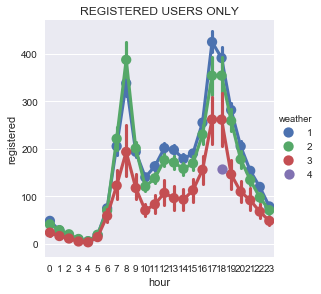

In [205]:
# REGISTERED USERS
sns.factorplot(data = train_df,
                  x = 'hour',
                  y = "registered", 
                  hue = "weather",
                  ci = 95
            
               )

sns.plt.title('REGISTERED USERS ONLY')

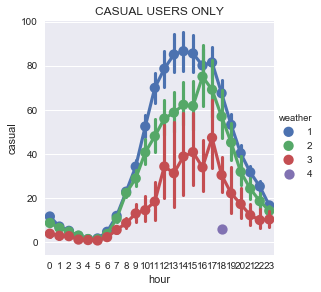

In [207]:
g= sns.factorplot(data = train_df,
                    x = 'hour',
                    y = "casual",
                    hue = "weather",
                    ci = 95
                   ) 

sns.plt.title('CASUAL USERS ONLY')
#note that the y-axis scales are different; there are many more users are in the 'registered' cohort. 

It appears that registered users and casual users have different usage patterns of city bikes.
Registered users use rental bikes disproportionately more during commuting hours (7-8am and 5-7pm), whereas casual cyclists' hourly usage usage patterns are more regular, peaking between 12pm and 4pm.

I think that observation in itself warrants running two separate models for casual and registered users and using the sum of the two predictions as the final 'count' dependent variable. Nonetheless, let's see if we can observe differences in usage patterns in weekly (day_of_week), monthly (month) timeframes. 

Additionally, we'll look at the relationship between the temperature and the demand for these two user groups. 

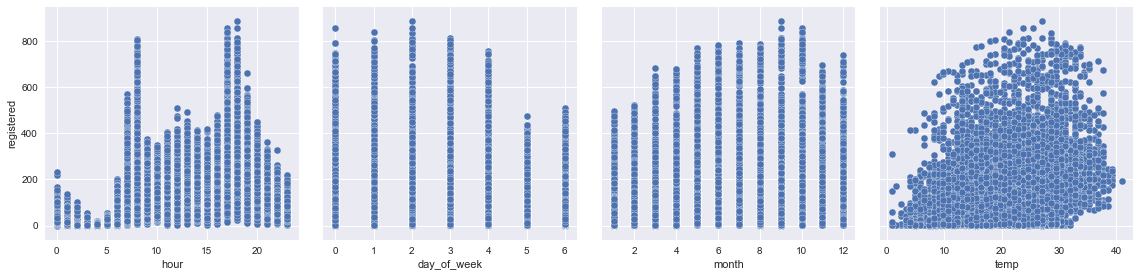

In [21]:
sns.pairplot(train_df, x_vars=['hour', 'day_of_week','month', 'temp'], y_vars='registered', diag_kind = 'hist', palette="Set3", aspect=1, size=4)

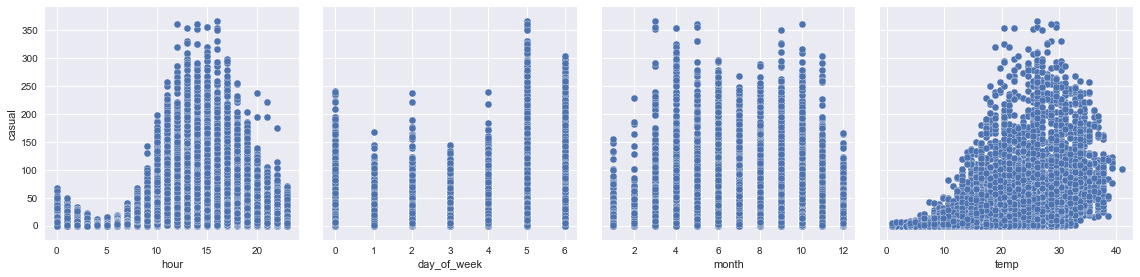

In [22]:
sns.pairplot(train_df, x_vars=['hour', 'day_of_week','month', 'temp'], y_vars='casual', palette="Set3",aspect=1, size=4)


Awesome! Two additional things I noticed from the comparison between the two user groups is:

- There is an apparent difference between demand on workdays vs weekends (casual users appear to be more keen to cycle on the weekends than on the workdays - the reverse is true for registered users). 
- Registered users appear to be less sensitive to low temperatures (no wonder; cycling commuters are a resilient bunch!)

#### One-hot encoding and dropping unnecessary features

Let's one-hot encode some categorical variables.

In [174]:
def onehot_encode(df, varlist):
    
        for var in varlist:
            dummies =  pd.get_dummies(df[var], prefix=var, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)
            df = pd.concat([df, dummies], axis=1)
            df.drop(var, inplace = True, axis=1)
        return df
    
    
to_onehot_encode = ['season',
                    'weather',
                    'year']

train_df = onehot_encode(df = train_df, varlist = to_onehot_encode)
test_df = onehot_encode(df = test_df, varlist = to_onehot_encode)

#let's drop the obsolete one-hot-encoded features and other unnecessary variables
to_drop = ['atemp', 'windspeed', 'month','hour','day_of_week']
train_df.drop(to_drop, inplace = True, axis = 1)
test_df.drop(to_drop, inplace = True, axis = 1)

In [26]:
train_df.keys()

Index(['holiday', 'workingday', 'temp', 'humidity', 'casual', 'registered',
       'count', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin',
       'month_cos', 'season_1', 'season_2', 'season_3', 'season_4',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'year_2011',
       'year_2012'],
      dtype='object')

In [27]:
test_df.keys()

Index(['holiday', 'workingday', 'temp', 'humidity', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'year_2011', 'year_2012'],
      dtype='object')

Let's now split the train data into two datasets - one containing dependent features we want to predict (Y) and the other one containing our independent features only (X). After that I'll split these into train and validation sets using sklearn's train_test_split.

In [28]:

Y = train_df[["count","registered","casual"]]
X = train_df.drop(["count","registered","casual"], axis = 1)

X_train, X_validate, y_train, y_validate = train_test_split(train_df.drop(["count","registered","casual"], axis = 1),
                                                            train_df[["count","registered","casual"]],
                                                            test_size=0.3, random_state=2)


### 4. Modelling

I'm going to use a few model types to probe for the most promising architecture for this problem.

I'll test the following regressors:

    - Linear regression
    - AdaBoost regressor
    - Random forest 
    - xgboost
    
Let's implement the scoring function Kaggle uses for this competition so I can compare my model's performance with the public leaderboard before submitting my solutions.

In [176]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypothesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

# Source: https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError


I'm guessing it's unlikely there's a clear linear relationship between the independent variables and the dependent variable, but let's start off with running a linear regression model to find out.

In [30]:
reg_casual = LinearRegression()
reg_registered = LinearRegression()

reg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
reg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

# Make predictions for total count ('count') based on a sum of predicted casual and registered users
pred_train = np.exp(reg_registered.predict(X= X_train)) + np.exp(reg_casual.predict(X= X_train))
pred_validate = np.exp(reg_registered.predict(X= X_validate)) + np.exp(reg_casual.predict(X= X_validate))

print("LINEAR REGRESSION\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))

LINEAR REGRESSION
----------------------------------------
RMSLE Train:  0.835579345474
RMSLE Validation:  0.811100444628


I guess that's an okay good result for a linear regression model in this context, but still nowhere near the kind of score I should be aiming at.

In [162]:
ada_reg_casual = AdaBoostRegressor(n_estimators=1000, learning_rate=1.0, loss='linear')
ada_reg_registered = AdaBoostRegressor(n_estimators=1000, learning_rate=1.0, loss='linear')

ada_reg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
ada_reg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(ada_reg_registered.predict(X_train)) + np.exp(ada_reg_casual.predict(X_train))
pred_validate =  np.exp(ada_reg_registered.predict(X_validate)) + np.exp(ada_reg_casual.predict(X_validate))

print("ADABOOST REGRESSOR\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))

ADABOOST REGRESSOR
----------------------------------------
RMSLE Train:  0.662688197001
RMSLE Validation:  0.659026098917


Adaboost showed a substantial improvement over the linear regression, but I didn't have luck making the score better with manual hyperparameter tuning and feature engineering. Let's see how Random Forest and xgboost do in this setting! 

In [31]:
rf_casual = RandomForestRegressor(n_estimators=1000, max_features=10)
rf_registered = RandomForestRegressor(n_estimators=1000, max_features=10)

rf_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
rf_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(rf_registered.predict(X_train)) + np.exp(rf_casual.predict(X_train))
pred_validate =  np.exp(rf_registered.predict(X_validate)) + np.exp(rf_casual.predict(X_validate))

print("RANDOM FOREST REGRESSOR\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))

RANDOM FOREST REGRESSOR
----------------------------------------
RMSLE Train:  0.119290882227
RMSLE Validation:  0.276817482928


The score my random forest model got on Kaggle is 0.408 - which is... pretty good!

Let's see if I can top this with xgboost. :)

In [33]:
#saving my submission file
test_pred1 = (np.exp(rf_casual.predict(test_df)) + np.exp(rf_registered.predict(test_df)))

df = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':df, 'count':test_pred1})
df.to_csv('20180104_submission_random_forest', index = False, columns=['datetime','count'])

In [34]:
xg_casual = xg.XGBRegressor(max_depth=8,min_child_weight=4,gamma=0,colsample_bytree=0.9,subsample=0.9) 
xg_registered = xg.XGBRegressor(max_depth=8,min_child_weight=4,gamma=0,colsample_bytree=0.9,subsample=0.9) 


'''XGBOOST
----------------------------------------
RMSLE Train:  0.15522870962
RMSLE Validation:  0.26488524148'''
    
    
xg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
xg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(xg_registered.predict(X_train)) + np.exp(xg_casual.predict(X_train)) 
pred_validate =  np.exp(xg_registered.predict(X_validate)) + np.exp(xg_casual.predict(X_validate))

print("XGBOOST\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))

XGBOOST
----------------------------------------
RMSLE Train:  0.15522870962
RMSLE Validation:  0.26488524148


This one got 0.413 on Kaggle - interestingly, it has a lower RSMLE validation error than Random Forest regressor.
Let's save this one submission and see if I can improve this score with GridsearchCV.

In [35]:
test_pred1 = (np.exp(xg_casual.predict(test_df)) + np.exp(xg_registered.predict(test_df)))

df = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':df, 'count':test_pred1})

df.to_csv('20180104_submission_xgboost', index = False, columns=['datetime','count'])

Let's implement a GridsearchCV function for xgboost

In [214]:
parameters = {'learning_rate': 0.07,
              'subsample': 1,
              'max_depth': 6,
              'min_child_weight': 5,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 0.8} #initial parameters



def gridsearch(parameters_tested, x, y):

    grid_search = GridSearchCV(estimator = xg.XGBRegressor(**parameters), 
                                param_grid = parameters_tested, 
                                n_jobs = 4,
                                iid = False,
                                cv = 5)

    grid_search.fit(x,y)
    print(grid_search.grid_scores_)
    print(grid_search.best_params_)
    print("\n")
    print(grid_search.best_score_)

As it's rather computationally heavy, I did the search in batches. After I got the outputs, I collapsed it into one cell and saved outputs as comments, so these sections are not too clunky.

In [148]:
'''
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(0,7,2)
}
gridsearch(param_test1, X_train, y_train['registered']) 
Optimal values were:
{'max_depth': 7, 'min_child_weight': 0}

param_test2 = {'gamma':[n/10.0 for n in range(0,6)]}
gridsearch(param_test2, X_train, y_train['registered'])
Optimal values were:
{'gamma': 0.0}

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
gridsearch(param_test3, X_train, y_train['registered'])
Optimal values were:
{'colsample_bytree': 0.7, 'subsample': 0.9}

param_test4 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] }
gridsearch(param_test4, X_train, y_train['registered'])
Optimal values were:
{'reg_alpha': 100}

'''

# FINAL PARAMETERS FOR 'REGISTERED' MODEL
# _______________________________________
#
parameters_registered = {'learning_rate': 0.07,
              'subsample': 0.9,
              'max_depth': 7,
              'min_child_weight': 0,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 0.7,
              'gamma': 0,
#             'reg_alpha': 100 #changed this, as it wasn't performing well
              'reg_alpha': 4
                        }



Now I'll do the same for the 'casual' model.

In [149]:
'''
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(0,7,2)}
gridsearch(param_test1, X_train, y_train['casual']) 
{'max_depth': 5, 'min_child_weight': 2}

param_test2 = {'gamma':[n/10.0 for n in range(0,6)]}
gridsearch(param_test2, X_train, y_train['casual'])
{'gamma': 0.4}

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]}
gridsearch(param_test3, X_train, y_train['casual'])
{'colsample_bytree': 0.9, 'subsample': 0.7}

param_test4 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] }
gridsearch(param_test4, X_train, y_train['casual'])
{'reg_alpha': 100}'''


# FINAL PARAMETERS FOR 'CASUAL' MODEL
# _______________________________________
parameters_casual = {'learning_rate': 0.07,
              'subsample': 0.7,
              'max_depth': 5,
              'min_child_weight': 2,
              'n_estimators': 1000,
              'seed':0,
              'colsample_bytree': 0.9,
              'gamma': 0.4,
              #'reg_alpha': 100 #changed this, as it wasn't performing well
              'reg_alpha': 4

                    }

In [151]:
# rerun with parameters found through CVsearch

xg_casual = xg.XGBRegressor(**parameters_casual) 
xg_registered = xg.XGBRegressor(**parameters_registered) 

xg_casual.fit(X = X_train, y = np.log1p(y_train['casual']))
xg_registered.fit(X = X_train, y = np.log1p(y_train['registered']))

pred_train =  np.exp(xg_registered.predict(X_train)) + np.exp(xg_casual.predict(X_train)) 
pred_validate =  np.exp(xg_registered.predict(X_validate)) + np.exp(xg_casual.predict(X_validate))

print("XGBOOST\n"+"-"*40)
print("RMSLE Train: ",rmsle(pred_train,np.exp(np.log1p(y_train['count']))))
print("RMSLE Validation: ",rmsle(pred_validate,np.exp(np.log1p(y_validate['count']))))

XGBOOST
----------------------------------------
RMSLE Train:  0.196181974031
RMSLE Validation:  0.259299230991


There's definitely value in L1 reguralization, given the discrepancy between the train and validation scores, but reg_alpha = 100 [recommended by the gridsearch function] was probably an overkill:

In [178]:
'''
Results for reg_alpha = 100:
----------------------------------------
RMSLE Train:  0.378822606431
RMSLE Validation:  0.383880715462
Kaggle score: 0.48853. #(lower than before gridsearch..)

'''

Rerunning the model with no L1 regularization (reg_alpha = 0 [default]) resulted in the following:

I've tried a bunch of arbitrary integers that'd be much closer to 0 than 100 but not ==0 and 4 gave me the best validation error and the best kaggle score (0.40376).

The score this combination received on Kaggle (0.40376 [top 7%]) beats the score achieved by the Random Forest regresor by a small margin. Let's save the submission file.

In [152]:
test_pred1 = (np.exp(xg_casual.predict(test_df)) + np.exp(xg_registered.predict(test_df)))

df = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':df, 'count':test_pred1})

df.to_csv('20180104_submission_xgboost_cv_alpha4', index = False, columns=['datetime','count'])

### 5. Conclusion

The XGboost model supplemented with a gridsearchCV achieved a score of 0.40376 (top 7%). 

There is surely a lot to be done to improve this score. The most obvious things are:

    - More feature engineering
    - Run a more comprehensive gridsearch function (on a GPU, perhaps)
    - Using other models (e.g. deep learning. I imagine RNNs could work quite well with this time series dataset)
    
#### Thank you for your time, and looking forward to hearing your feedback on this! :)